## Background

A canonical inverse problem is to infer the spatially varying parameter field $K(x)$ in the following elliptic PDE
$$
-\nabla\cdot\left[ K \nabla h\right] = f,
$$
where $h(x)$ is the solution of the PDE and $f(x)$ is a source term.   We consider this PDE in a one dimensional (i.e., $x\in\mathbb{R}$) setting with boundary conditions given by
$$
\begin{aligned}
h(0) &= 0\\
\left. \frac{\partial h}{\partial x}\right|_{x=1} &= 0.
\end{aligned}
$$

This equation can be used to describe many different diffusive processes, such as heat conduction, groundwater flow, and contaminant diffusion.    This example interprets the PDE in the context of groundwater flow, meaning that $h(x)$ represents the hydraulic head in a confined aquifer, $f(x)$ represents recharge of water entering the aquifer, and $k(x)$ is the hydraulic conductivity, which describes how difficult it is for water to pass through the aquifer.

The hydraulic head $h(x)$ can be measured at individual points $x_1,x_2,\ldots,x_M$ by drilling boreholes into an aquifer and measuring the pressure in the borehole.  The conductivity $K(x)$ however, cannot be observed directly.   We will therefore consider estimating the hydraulic conductivity $K(x)$ from noisy measurements of $h(x_1), h(x_2),\ldots, h(x_M)$.



**The goal of this example is to demonstrate the use of MUQ for solving Bayesian inverse with PDE models.**   The implementation of the model itself will not be discussed in details.   The implementation of the PDE solver, adjoint gradients, and Hessian information is described in detail in the [FlowEquation](../../../../Modeling/FlowEquation/python/DarcyFlow.ipynb) modeling example.

### Imports

In [1]:
import muq.Modeling as mm 
import muq.SamplingAlgorithms as ms 
import muq.Utilities as mu
import muq.Approximation as ma 
import muq.Optimization as mo

from FlowEquation import FlowEquation

import numpy as np
import matplotlib.pyplot as plt 

## Inverse Problem Formulation

$\theta = \log K$

$$
\pi(\theta | y=y_{obs}) \propto \pi(y=y_{obs} | \theta) \pi(\theta)
$$

#### Discretization
Assume that $x\in[0,1]$ and that the conductivity field is defined as piecwise constant on $N$ uniformly sized cells dividing up $[0,1]$.  There are $N+1$ nodes in the discretization.


In [2]:
class Discretization:
    
    def __init__(self,numCells):
        self.numCells = numCells
        self.numNodes = numCells+1

        self.nodeLocs = np.linspace(0,1,numCells+1)

        self.cellLocs = 0.5*(self.nodeLocs[:-1] + self.nodeLocs[1:]).reshape(1,-1)

In [3]:
# Define the mesh
numCells = 50
mesh = Discretization(numCells)

#### Prior Distribution
By definition, the conductivity field $K(x)$ must be positive.   We will therefore define a prior distribution $\log K(x)$ to ensure that $K(x)>0$.   In particular, we will model the log conductivity field as a zero mean Gaussian process with covariance kernel $k(x,x^\prime)$:

$$
\log k(x) \sim GP(0,k(x,x^\prime))
$$

Here, we employ a Matern kernel with parameter $\nu=3/2$.  This kernel takes the form

$$
k(x,x^\prime) = \sigma^2 \left(1+\frac{\sqrt{3}\|x-x^\prime\|}{L}\right)\exp\left[-\frac{\sqrt{3}\|x-x^\prime\|}{L}\right],
$$

where $\sigma^2$ is the marginal variance of the prior distribution and $L$ is the correlation lengthscale of the kernel.  Note that this kernel results in random fields that have continuous first derivatives, but discontinuous second derivatives.   More generally, Matern kernels with $\nu=p+1/2$ result in fields with $p$ continuous derivatives.

The MUQ `GaussianProcess` class is constructed from a mean function and a covariance kernel.  The `Discretize` takes a vector of points and evaluates constructs a finite dimensional Gaussian distribution by evaluating the mean function at each point and the covariance kernel at each pair of points.

The discretization of the PDE assumes that $K(x)$ is piecewise constant over grid cell.  Formally setting $\log K_i$ to the average of $\log K(x)$ over the cell $[x_i,x_{i+1})$ would result in a prior covariance matrix of the form

$$
\text{Cov}\left[\log K_i, \log K_j\right] = \frac{1}{(x_{i+1}-x_{i})(x_{j+1}-x_{j})}\int_{x_i}^{x_{i+1}} \int_{x_j}^{x_{j+1}} k(x_1,x_2) \,\,dx_2dx_1
$$

where $x_i$ is the location of the node on the left edge of cell $i$.  Here we approximate this covariance by simply evaluating the covariance kernel at the centroids of the cells: 

$$
\text{Cov}\left[\log K_i, \log K_j\right] \approx k\left(\frac{1}{2}(x_i + x_{i+1}),\,\, \frac{1}{2}(x_j + x_{j+1}) \right).
$$

Note that this is equivalent to approximating the integrals with a midpoint rule and a single interval.

**The vector $\log K = \left[\log K_1, \ldots, \log K_N\right]$ will be used to denote the collection of log conductivities on each cell.** 

In [4]:
def CreatePrior(mesh):
    
    # Define the prior distribution
    priorVar    = 1.0
    priorLength = 0.05
    priorNu     = 3.0/2.0
    
    xDim = 1     # Dimension of x
    fieldDim = 1 # Dimension of state variable in random field (i.e., dimension of K(x))
    
    covKernel = ma.MaternKernel(xDim, priorVar, priorLength, priorNu) # The first argument "1" specifies we are working in 1d
    
    meanFunc = ma.ZeroMean(xDim,fieldDim) # dimension of x, components in k(x) if it was vector-valued

    priorGP = ma.GaussianProcess(meanFunc,covKernel)

    return priorGP.Discretize(mesh.cellLocs)

In [5]:
priorDist = CreatePrior(mesh)
priorDens = priorDist.AsDensity() # <- Create a ModPiece that evaluates the log density of the Gaussian prior

#### True data
After discretizing the PDE, the hydraulic head $h(x)$ is represented as a piecewise linear function characterized by values at the $N+1$ nodes in the discretization.    We will assume that every $P=\lceil (N+1)/M\rceil$ of these nodes is observed, resuling in a total of $M$ hydraulic noisy head observations.  Let $y_{obs}$ denote these observations.  

For this example, we will synthetically generate data $y_{obs}$ using a "true" log conductivity field $\log K(x) = \cos(10x)$ and a mesh with $2N$ cells.  Noise with variance $\sigma^2$ is added to the model output to simulate $y_{obs}$.

The `SliceOperator` class in MUQ is used to downscale the model output, which as $2N+1$ components to the observable quantity $y$, which has $M$ components.   Using numpy notation, the output of `SliceOperator` for an input vector $x$ is `x[startInd:endInd:skip]`.   The arguments to the `SliceOperator` constructor are `x.shape[0]`, `startInd`, `endInd`, and `skip`.

In [6]:
def GetTrueLogConductivity(mesh):
    return np.cos(10.0*mesh.cellLocs)

In [7]:
def GenerateData(mesh, obsThin, obsVar, numRefine=2):

    # Generate the data
    fineMesh = Discretization(numRefine*mesh.numCells)
    trueCond = np.exp( GetTrueLogConductivity(fineMesh) )

    # Create the model with twice the mesh resolution
    recharge = np.ones(fineMesh.numCells)
    mod = FlowEquation(recharge)

    # Solve the forward problem with the true conductivity
    trueSol = mod.Evaluate( trueCond )[0]

    # Take every N node as an "observation"
    slicer = mm.SliceOperator(fineMesh.numNodes, 0, fineMesh.numCells, numRefine*obsThin)
    
    yobs = slicer.Evaluate([trueSol])[0] + np.sqrt(obsVar)*np.random.randn(slicer.outputSizes[0])
    
    return yobs, trueSol, fineMesh 

In [8]:
# The value of thinning parameter "P"
obsThin = 4  

# \sigma_{\epsilon}^2
obsVar = 0.01*0.01 

# Controls the number of cells in the fine mesh used to generate data (numCells = numRefine*N)
numRefine = 2 

# Generate the data
data, trueHead, fineMesh = GenerateData(mesh, obsThin, obsVar,2)

We can now plot the noisy observational data and the true hydraulic head $h(x)$ that generated it.

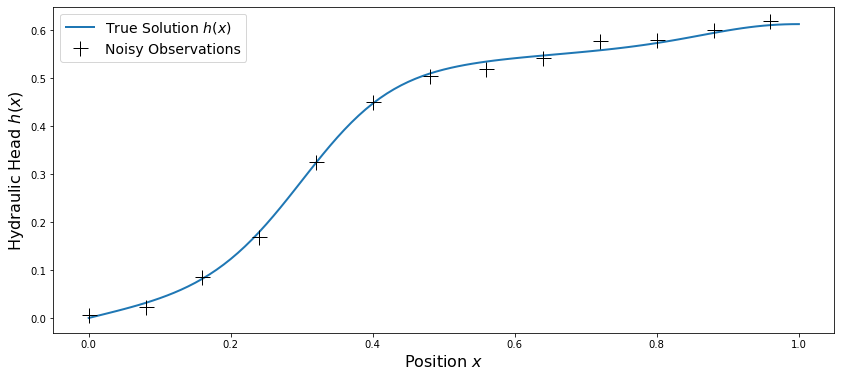

In [9]:
plt.figure(figsize=(14,6))
plt.plot(fineMesh.nodeLocs, trueHead, label='True Solution $h(x)$', linewidth=2)
plt.plot(fineMesh.nodeLocs[::obsThin*numRefine], data, '+k', label='Noisy Observations', markersize=15)

plt.legend(fontsize=14)
plt.xlabel('Position $x$',fontsize=16)
plt.ylabel('Hydraulic Head $h(x)$', fontsize=16)
plt.show()

#### Likelihood Function

To define a likelihood function $\pi(y|\theta)$, we need to construct a statistical model relating the PDE output $[h(x_0), h(x_P),\ldots, h(x_M)]$ to the observable quantity $y$.   Here, we assume that $y$ is  related to the hydraulic heads through an additive Gaussian error model

$$
y = \left[ \begin{array}{l} h(x_{0}; \theta)\\ h(x_{P}; \theta)\\ h(x_{2P}; \theta)\\ \vdots\\ h(x_M; \theta) \end{array} \right] + \epsilon,
$$

where $\epsilon\sim N(0,\sigma_{\epsilon}^2I)$ is an $M$-dimensional normal random variable with variance $\sigma_{\epsilon}^2$.   With this noise model, the distribution of the observable quantity $y$ given log conductivities $\theta$  is then just normal distribution centered at the model output

$$
\pi(y | \theta) = N\left([h(x_0), h(x_P),\ldots, h(x_M)], \,\, \sigma_{\epsilon}^2I\right)
$$

In [10]:
def ConstructLikelihood(mesh, data, obsThin, obsVar, forwardMod):
   
    graph = mm.WorkGraph()
    graph.AddNode(mm.ExpOperator(mesh.numCells), "Conductivity")
    
    graph.AddNode(forwardMod, "Forward Model")
    graph.AddEdge("Conductivity", 0, "Forward Model", 0)
    
    graph.AddNode(mm.SliceOperator(mesh.numNodes,0,mesh.numCells,obsThin), "Observables")
    graph.AddEdge("Forward Model", 0, "Observables", 0)
    
    likelihood = mm.Gaussian(data, obsVar*np.ones(data.shape[0]))
    
    graph.AddNode(likelihood.AsDensity(), "Likelihood")
    graph.AddEdge("Observables", 0, "Likelihood", 0)
    
    graph.Visualize("LikelihoodGraph.png")
    
    return graph.CreateModPiece("Likelihood"), graph.CreateModPiece("Forward Model")

In [11]:
# Define the forward model
recharge = np.ones(mesh.numCells)
forwardMod = FlowEquation(recharge)

# Build the likelihood function and the mapping from logK->h
likelihood, model = ConstructLikelihood(mesh, data, obsThin, obsVar, forwardMod)

If [graphviz](https://graphviz.org/) is installed on your computer, the `graph.Visualize()` function will produce a file called "LikelihoodGraph.png" with a visualization of the components making up the likelihood function.   The following markdown cell displays the image that is produced.

<img src="./LikelihoodGraph.png" alt="Likelihood Graph" width="300"/>

#### Create Posterior
Using the likelihood function and prior density defined above, it is now possible to combine them to define the posterior density.   The `DensityProduct` ModPiece is used for this.  It takes 2 or more inputs representing log densities and returns the log of the density product (i.e., the sum of the log densities).

In [12]:
def ConstructPosterior(prior, likelihood):
   
    graph = mm.WorkGraph()
    graph.AddNode(mm.IdentityOperator(mesh.numCells), "Log Conductivity")
    
    graph.AddNode(prior, "Prior")
    graph.AddEdge("Log Conductivity", 0, "Prior", 0)
    
    graph.AddNode(likelihood, "Likelihood")
    graph.AddEdge("Log Conductivity",0, "Likelihood",0)
    
    graph.AddNode(mm.DensityProduct(2), "Posterior")
    graph.AddEdge("Prior",0,"Posterior",0)
    graph.AddEdge("Likelihood",0,"Posterior",1)

    graph.Visualize("PosteriorGraph.png")
    
    return graph.CreateModPiece("Posterior")

In [13]:
posterior = ConstructPosterior(priorDens, likelihood)

Like we did for the likelihood function above, it is possible to visualize the direct graph used to define the posterior density using the `Visualize` function of the `WorkGraph` class.

<img src="./PosteriorGraph.png" alt="Likelihood Graph" width="400"/>

## Compute MAP Point
Now that we've define the posterior, we can start trying to estimate the parameters $\theta = \log K$ in the model.  The following cell computes the MAP point using MUQ's Newton-Steihaug trust region optimizer.   The optimizer minimizes function, while we want to maximize the log posterior density.  The `ModPieceCostFunction` class allows us to specify a negative scaling of the log posterior to flip the maximization problem into a minimization problem that the optimizer can handle.    

In addition to the trust region solver used here, MUQ also can also leverage any method implemented in [NLOPT](https://nlopt.readthedocs.io/en/latest/).  Try changing the `'NewtonTrust'` string to `'LBFGS'` to use the NLOPT limited memory BFGS implementation.

In [14]:
def ComputeMAP(logPost, startPt):
    
    options = {
        'Algorithm' : 'NewtonTrust', # Newton-Steihaug trust region method.  Options also include NLOPT optimizers like LBFGS
        'PrintLevel' : 1,
        'Ftol.AbsoluteTolerance' : 1e-4
    }
    
    # Define the objective function as the negative log posterior 
    objective = mo.ModPieceCostFunction(logPost, -1.0)
    
    # Construct the optimizer and minimize the objective
    solver = mo.Optimizer.Construct(objective, options)
    xopt, fopt = solver.Solve([ startPt ])
    
    return xopt

In [17]:
# Use a random draw from the prior as a starting point for MCMC
startPt = priorDist.GetMean()
hessAct = posterior.ApplyHessian(0,0,0,[startPt],np.ones(1), np.random.rand(startPt.shape[0]))
print(hessAct)

mapPt = ComputeMAP(posterior, startPt)

print(mapPt)

RuntimeError: Could not add an edge from "Forward Model_Gradient[0,0]_Jacobian[0,0]" to "Conductivity_Gradient[0,0]_Jacobian[0,1]" because the source node "Forward Model_Gradient[0,0]_Jacobian[0,0]" does not exist in the graph.

#### Plot the MAP Point

In [ ]:
trueLogK = GetTrueLogConductivity(mesh).ravel()

fig, axs = plt.subplots(nrows=2,figsize=(12,8))
axs[0].plot(mesh.cellLocs.ravel(), mapPt,label='MAP Point')
axs[0].plot(mesh.cellLocs.ravel(), trueLogK, '--k', label='True $\log k(x)$')
axs[0].plot(mesh.cellLocs.ravel(), startPt, '--g', label='Starting Point for Optimization')
axs[0].legend()

truePred = model.Evaluate([trueLogK])[0]
mapPred = model.Evaluate([mapPt])[0]
startPred = model.Evaluate([startPt])[0]

axs[1].plot(mesh.nodeLocs, mapPred, label='Prediction at MAP')
axs[1].plot(mesh.nodeLocs, truePred,'--k',label='True Prediction')
axs[1].plot(mesh.nodeLocs, startPred, '--g', label='Starting Prediction')
axs[1].plot(mesh.nodeLocs[0:-1:obsThin],data,'+k',markersize=12,label='Observations')
axs[1].legend()

plt.show()

## Sample Posterior with DILI

In [ ]:
def SampleDILI(posterior, startPt, numSamps):
    
    lisOpts = {
        'Method' : "MHKernel",
        "Proposal" : "Prop",
        "Prop.Method" : "MALAProposal",
        "Prop.StepSize" : 0.15
    }
    
    csOpts = {
        "Method" : "MHKernel",
        "Proposal" : "Prop",
        "Prop.Method" : "CrankNicolsonProposal",
        "Prop.Beta" : 0.8,
        "Prop.PriorNode" : "Prior"
    }
    
    opts = {
        "NumSamples" : numSamps,
        "BurnIn" : 0,
        "PrintLevel" : 3,
        "HessianType" : "Exact",
        "Adapt Interval" : 0,
        "Initial Weight" : 100,
        "Prior Node" : "Prior",
        "Likelihood Node" : "Likelihood",
        "LIS Block": "LIS",
        "LIS" : lisOpts,
        "CS Block": "CS",
        "CS" : csOpts
    }
    
    # create a sampling problem
    problem = ms.SamplingProblem(posterior)
    
    # Construct the DILI kernel and MCMC sampler
    kernel = ms.DILIKernel(opts, problem)
    sampler = ms.SingleChainMCMC(opts, [kernel])
    
    return sampler.Run([startPt]) 

In [ ]:
numSamps = 100000
diliSamps = SampleDILI(posterior, mapPt, numSamps)

In [ ]:
diliEss = diliSamps.ESS(method='MultiBatch')
print('DILI:\n  Multivariate ESS: {:5d}'.format(int(diliEss[0])))

### Plot DILI Results

In [ ]:
samps = diliSamps.AsMatrix()

fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(14,10))
axs[0].plot(samps[0,:])
axs[0].set_ylabel('$\log K_0\f$',fontsize=16)
axs[0].set_title('Selected Traces for DILI MCMC',fontsize=18)

axs[1].plot(samps[-1,:])
axs[1].set_ylabel('$\log K_{{ {} }}$'.format(samps.shape[0]-1),fontsize=16)
axs[1].set_xlabel('MCMC Step', fontsize=16)
axs[1].set_xlim([0,samps.shape[1]-1])

plt.subplots_adjust(hspace=0.05)

In [ ]:
plt.figure(figsize=(14,5))

plotInd = int(0.5*samps.shape[0])
plt.acorr(samps[plotInd,:]-np.mean(samps[plotInd:]),maxlags=10000)
plt.xlabel('Lag', fontsize=16)
plt.ylabel('Autocorrelation', fontsize=16)
plt.title('Autocorrelation of $\log K_{{ {} }}$ in DILI chain'.format(plotInd),fontsize=18)
plt.show()

## Sample Posterior with pCN

In [ ]:
def SamplePCN(posterior, startPt, numSamps):
    
    kernOpts = {
        "Method" : "MHKernel",
        "Proposal" : "Prop",
        "Prop.Method" : "CrankNicolsonProposal",
        "Prop.Beta" : 0.1,
        "Prop.PriorNode" : "Prior"
    }
    
    opts = {
        "NumSamples" : numSamps, # number of Monte Carlo samples,
        "BurnIn" : 0,
        "PrintLevel" : 3,
        "KernelList" : "Kernel1",
        "Kernel1" : kernOpts
    }
    
    
    #create a sampling problem
    problem = ms.SamplingProblem(posterior)

    sampler = ms.SingleChainMCMC(opts,problem)

    return sampler.Run([startPt]) # Use a true posterior sample to avoid burnin

In [ ]:
pcnSamps = SamplePCN(posterior, startPt, numSamps)

In [ ]:
pcnEss = pcnSamps.ESS(method='MultiBatch')
print('pCN:\n  Multivariate ESS: {:5d}'.format(int(pcnEss[0])))

### Plot pCN Results

In [ ]:
samps = pcnSamps.AsMatrix()

fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(14,10))
axs[0].plot(samps[0,:])
axs[0].set_ylabel('$\log K_0\f$',fontsize=16)
axs[0].set_title('Selected Traces for pCN MCMC',fontsize=18)

axs[1].plot(samps[-1,:])
axs[1].set_ylabel('$\log K_{{ {} }}$'.format(samps.shape[0]-1),fontsize=16)
axs[1].set_xlabel('MCMC Step', fontsize=16)
axs[1].set_xlim([0,samps.shape[1]-1])

plt.subplots_adjust(hspace=0.05)


In [ ]:
plt.figure(figsize=(14,5))

plt.acorr(samps[plotInd,:]-np.mean(samps[plotInd:]),maxlags=10000)
plt.xlabel('Lag', fontsize=16)
plt.ylabel('Autocorrelation', fontsize=16)
plt.title('Autocorrelation $\log K_{{ {} }}$ in pCN chain'.format(plotInd),fontsize=18)
plt.show()